In [1]:
# Imports
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

from edinburgh_challenge.constants import police_stations, police_stations_dict, Location
from edinburgh_challenge.utility import generate_early_shift_distributions, bng_to_latlong
from edinburgh_challenge.models import NaiveModel, GreedyModel, EnhancedModel, SimplifiedModelNotBest, SimplifiedModel, ClosestPoliceStationModel
from edinburgh_challenge.simulation import *
from edinburgh_challenge.processing import *

In [2]:
start_date="01-01-2023"

## Estates

In [3]:
estates_df = load_estates_df()

In [4]:
ps_coords, shift_distribution, shift_distribution_weekend, police_stations_dict, police_stations = generate_simulation_specs(estates_df)

In [5]:
#latitudes, longitudes = [], []
#for index, row in custody_suites_df.iterrows():
#    lat, lon = bng_to_latlong(row['X (Easting)'], row['Y (Northing)'])
#    latitudes.append(lat)
#    longitudes.append(lon)

#custody_suites_df["Latitude"] = latitudes
#custody_suites_df["Longitude"] = longitudes

In [6]:
#custody_suites_df.head()

## Custody Suites

In [7]:
max_custody_df = load_max_custody_df()

In [8]:
custody_df, custody_inds_df = process_custody_df(max_custody_df, start_date=start_date)

In [9]:
custody_df.head()

Day  Hour DivisionID  Total_Custodies  Max_Travel_Time  Max_Wait_Time  \
0    1     1          G                1         2.666667       2.483333   
1    1     2          G                1         2.666667       2.483333   
2    1     3          G                1         2.666667       2.483333   
3    1     4          G                1         2.666667       2.483333   
4    1     5          G                1         2.666667       2.483333   

   Max_Processing_Time  
0             9.333333  
1             9.333333  
2             9.333333  
3             9.333333  
4             9.333333

## Incidents

In [10]:
# Load the incidents data
incidents_df = load_incidents_df()

In [11]:
incidents_df.head()

Unnamed: 0            ISR_NO    DATETIME_CREATED  \
2754137     1377068  PS-20180101-0004 2018-01-01 00:00:30   
2754136     1377067  PS-20180101-0007 2018-01-01 00:01:05   
2754135     1377066  PS-20180101-0010 2018-01-01 00:01:53   
2754134     1377065  PS-20180101-0011 2018-01-01 00:02:08   
2754133     1377064  PS-20180101-0015 2018-01-01 00:03:48   

         Deployment_Time_Mins POLICE_WEEK_DAY_CREATED DivisionID  LATITUDE  \
2754137                   NaN                     Fri          U  639591.0   
2754136                  95.0                     Fri          Q  654836.0   
2754135                  61.0                     Fri          G  665850.0   
2754134                   NaN                     Fri          G  665760.0   
2754133                   NaN                     Fri          G  669028.0   

         LONGITUDE  GIS_LATITUDE  GIS_LONGITUDE Call_Priority  
2754137   242829.0       55.6244       -4.49769        PROMPT  
2754136   264022.0       55.7677       -4.16897      STANDARD  
2754135   260293.0       55.8655       -4.23402     IMMEDIATE  
2754134   258341.0       55.8641       -4.26514     IMMEDIATE  
2754133   251550.0       55.8914       -4.37534     IMMEDIATE

In [12]:
avg_deployment_df = load_deployment_df()

In [13]:
# Incidents File preprocessing
incidents_data = preprocess_incidents(incidents_df, avg_deployment_df, ps_coords, n_values=600000, start_date=start_date)

In [14]:
incidents_data.head()

latitude  longitude  day  hour  time   priority  \
urn                                                                 
PS-20221226-0002   55.6470   -4.74083    1     0     0     Prompt   
PS-20221226-0005   55.6369   -4.75306    1     0     0  Immediate   
PS-20221226-0007   55.6360   -4.75625    1     0     0     Prompt   
PS-20221226-0008   56.0339   -4.54617    1     0     0     Prompt   
PS-20221226-0012   55.8720   -4.29979    1     0     0     Prompt   

                  deployment_time  station_1  station_2  station_3  ...  \
urn                                                                 ...   
PS-20221226-0002         0.216667  24.885015  17.238052  26.709897  ...   
PS-20221226-0005         0.333333  25.692636  18.044414  27.530764  ...   
PS-20221226-0007         1.050000  25.828422  18.180290  27.664601  ...   
PS-20221226-0008         1.300000  16.481523  17.241841  15.273391  ...   
PS-20221226-0012         2.616667   2.438922   6.091903   3.590144  ...   

                  station_69  station_70  station_71  station_72  sno  \
urn                                                                     
PS-20221226-0002   59.667003   48.379797   37.147068   52.398692    1   
PS-20221226-0005   59.568933   47.802146   37.208550   51.616745    2   
PS-20221226-0007   59.623011   47.769466   37.286295   51.530323    3   
PS-20221226-0008   75.952011   74.071146   51.854211   80.126209    4   
PS-20221226-0012   61.620771   63.267969   37.661655   72.515686    5   

                  resolved  resolving_officer  allocation_time  response_time  \
urn                                                                             
PS-20221226-0002     False               None             None           None   
PS-20221226-0005     False               None             None           None   
PS-20221226-0007     False               None             None           None   
PS-20221226-0008     False               None             None           None   
PS-20221226-0012     False               None             None           None   

                  resolution_time  
urn                                
PS-20221226-0002             None  
PS-20221226-0005             None  
PS-20221226-0007             None  
PS-20221226-0008             None  
PS-20221226-0012             None  

[5 rows x 85 columns]

### Deleting unused variables

In [15]:
len(police_stations)

72

In [16]:
del avg_deployment_df, estates_df

## Testing the Simulation

In [17]:
class Simulator:
    SPEED_MPH = 30  # Speed in miles per hour

    def __init__(self, df: pd.DataFrame, police_stations: List[PoliceStation], 
                 shift_distribution: ShiftDistribution, 
                 shift_distribution_weekend: ShiftDistribution,
                 custody_suites_df: pd.DataFrame,
                 custody_inds_df:pd.DataFrame,
                 n_days: float = 7,
                 verbose:int=0):
        
        self.df = df
        self.custody_incidents_df = custody_suites_df
        self.custody_inds_df = custody_inds_df
        
        self.police_stations = police_stations
        self.station_coords = [(ps.location.x, ps.location.y) for ps in self.police_stations]
        self.shift_distribution = shift_distribution
        self.shift_distribution_weekend = shift_distribution_weekend
        self.current_time = 0
        self.officers = { key: [] for key in shift_distribution["Early"].keys() } # Station_1, Station_2 and Station_3
        self.verbose = verbose
        self.n_days = n_days
        self.hours = [i for i in range(24*self.n_days + 1)]
        self.hour_index = 0
        self.return_times = [] # array keeps a track of return times of officers

        # This resolved incidents is made to keep a track of when an incident
        # is allocated to an officer. This is to conduct the evaluating model check
        self.resolved_incidents = [] # This list keeps a track and order of the resolved incidents as they are allocated

        # Making the df compatible with data structures
        df.columns = [x.lower() for x in df.columns]

        self.officers_by_shift = {
            "Weekday":{
                "Day":{},
                "Night":{},
                "Early":{}
            }, 
            
            "Weekend":{
                "Day":{},
                "Night":{},
                "Early":{}  
            }

        }
        

    def print_dashboard(self, allocations):
        print(f"\n--- Day {self.current_time // 24 + 1}, Hour {self.current_time % 24} ---")
        pending_cases = [inc for inc in self.cumulative_incidents if not inc.resolved]
        print(f"Pending Cases: {len(pending_cases)}")
        print("Pending Incident URNs:", [inc.urn for inc in pending_cases])

        inv_allocations = {v: k for k, v in allocations.items()}

        for station, officers in self.officers.items():
            print(f"\n{station}:")
            for officer in officers:
                # Find the incident the officer is currently assigned to
                if officer.name in inv_allocations.keys():
                    status = inv_allocations[officer.name]
                else:
                    status = "Busy"
                print(f"  - {officer.name}: {status}")

    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 3956  # Radius of Earth in miles. Use 6371 for kilometers
        return c * r


    def generate_incidents_for_hour(self):
        for global_time, hour_incidents in self.df.groupby('time'):
            incidents = []

            for urn, row in hour_incidents.iterrows():
                deployment_time = row["deployment_time"]
                station_cols = [f"station_{i+1}" for i in range(len(self.station_coords))]

                distances = {col: row[col] for col in station_cols}

                incidents.append(Incident(**row.drop(["deployment_time", "time", "sno"] + station_cols).to_dict(),
                                          urn=urn, 
                                          deployment_time=deployment_time,
                                          distances=distances,
                                          global_time=global_time))

            yield incidents

    def generate_custodies_for_hour(self):
        for _, division_cincs in self.custody_incidents_df.groupby(['Day', 'Hour']):
            cins = []
            for _, row in division_cincs.iterrows():
                num_incidents = int(row['Total_Custodies'])
                for p in range(num_incidents):
                    urn = f"CI_{row['Day']}_{row['Hour']}_{row['DivisionID']}_{p}"
                    max_travel_time = row['Max_Travel_Time'] 
                    max_wait_time = row['Max_Wait_Time']  
                    max_processing_time = row['Max_Processing_Time'] 
                    deployment_time = max_travel_time+max_wait_time+max_processing_time
                    incident = CustodyIncident(urn=urn, 
                                               hour=row['Hour'], 
                                               day=row['Day'], 
                                               division=row['DivisionID'], 
                                               max_travel_time=max_travel_time, 
                                               max_wait_time=max_wait_time,
                                               max_processing_time=max_processing_time,
                                               global_time=self.current_time)
                    cins.append(incident)
            yield cins
            #yield []   

            
    def data_to_incident(self, urn, row):
        deployment_time = row.pop("deployment_time")
        global_time = row.pop("time")  # Not needed as we use global_time
        station_cols = [f"station_{i+1}" for i in range(len(self.station_coords))]
        distances = row[station_cols].to_dict()
        row = row.drop(station_cols)
        return Incident(**row,
                          urn=urn, 
                          deployment_time=deployment_time,
                          distances=distances,
                          global_time=global_time)
        


#    def update_officers_for_shift(self, shift):
#        for station, num_officers in self.shift_distribution[shift].items():
#            # Update the number of officers for each station
#            self.officers[station] = [Officer(f"Officer_{station}_{shift}_{i}", station=station) for i in range(num_officers)]
    
    def create_officers_for_shift(self):
        for wd in self.officers_by_shift.keys():
            is_weekday = wd == "Weekday"
            sd = self.shift_distribution if is_weekday else self.shift_distribution_weekend
            for shift in ["Day", "Early", "Night"]:
                for station, num_officers in sd[shift].items():
                    # Update the number of officers for each station
                    day = "Weekday" if is_weekday else "Weekend"
                    self.officers_by_shift[day][shift][station] = [Officer(f"Officer_{station}_{day}_{shift}_{i}", station=station) for i in range(num_officers)]
        
    def add_officers_for_shift(self, shift, is_weekday):
        sd = self.shift_distribution if is_weekday else self.shift_distribution_weekend 
        for station, num_officers in sd[shift].items():
            # Update the number of officers for each station
            day = "Weekday" if is_weekday else "Weekend"
            self.officers[station] += self.officers_by_shift[day][shift][station]
            
    def remove_officers_for_shift(self, shift):
        for station, num_officers in self.shift_distribution[shift].items():
            # Update the number of officers for each station
            self.officers[station] = [off for off in self.officers[station] if shift not in off.name ]

            
    def process_allocations(self, allocations):
        # Prepare a set of urns to remove from pending incidents
        urns_to_remove = set()

        # Build a dictionary for fast officer lookup
        officer_dict = {off.name: off for station_officers in self.officers.values() for off in station_officers}

        # List of updates to perform on the DataFrame
        updates = []
        custody_updates = []

        for urn, officer_id in allocations.items():
           # if urn == "PS-20180105-3585":
            #    print(f'{allocations=}')
            # Access the row as a Series for fast column access
            is_custody_incident = "CI" in urn
            
            if not is_custody_incident:
                incident = self.df.loc[urn]

                if officer_id is None:
                    if not pd.isna(incident["resolved"]):  # If the incident is present and resolved is not NaN
                        self.df.at[urn, "resolved"] = False
                    continue

                officer = officer_dict.get(officer_id)
                if officer and officer.available:
                    travel_time = incident[officer.station] / self.SPEED_MPH
                    officer.available = False  # Mark officer as busy
                    officer.return_time = self.current_time + 2*travel_time + incident["deployment_time"]
                    self.return_times.append(officer.return_time)
                    if (officer.return_time < np.ceil(self.current_time)):
                        self.return_times_within_hour.append(officer.return_time)
                        sorted(self.return_times_within_hour)

                    # Collect the updates to perform in a single DataFrame operation
                    updates.append((urn, 
                                    True, 
                                    officer.name, 
                                    self.current_time, # allocation_time
                                    self.current_time + travel_time, # response_time
                                    officer.return_time # resolution_time
                                   )) 
                    urns_to_remove.add(urn)
            else:
                incident = self.custody_inds_df.loc[urn]
                officer = officer_dict.get(officer_id)
                if officer and officer.available:
                    travel_time = incident["max_travel_time"]
                    officer.available = False  # Mark officer as busy
                    officer.return_time = self.current_time + incident["max_processing_time"] + 2*travel_time + incident["max_wait_time"]
                    self.return_times.append(officer.return_time)
                    if (officer.return_time < np.ceil(self.current_time)):
                        self.return_times_within_hour.append(officer.return_time)
                        sorted(self.return_times_within_hour)
                    self.custody_inds_df.at[urn, "resolution_time"] = officer.return_time - travel_time
                    self.custody_inds_df.at[urn, "resolving_officer"] = officer.name
                    
                    urns_to_remove.add(urn)
                        
                    # Collect updates for custody_df
                

        # Apply the collected updates to the DataFrame
        for urn, resolved, resolving_officer, allocation_time, response_time, resolution_time in updates:
            self.df.at[urn, "resolved"] = True
            self.df.at[urn, "resolving_officer"] = resolving_officer
            self.df.at[urn, "allocation_time"] = allocation_time
            self.df.at[urn, "response_time"] = response_time
            self.df.at[urn, "resolution_time"] = resolution_time
            
        # Update pending_incidents based on urns_to_remove
        self.pending_incidents = [inc for inc in self.pending_incidents if inc.urn not in urns_to_remove]

        # Update officers' availability in officer_dict
        for officer_id in allocations.values():
            officer = officer_dict.get(officer_id)
            if officer:
                officer.available = False  # Mark officer as busy

        return urns_to_remove  # Return urns removed from pending_incidents


    def update_officer_availability(self):
        for station, officers in self.officers.items():
            for officer in officers:
                if self.current_time >= officer.return_time:
                    officer.available = True
                else:
                    officer.available = False 


    def get_return_times_for_next_hour(self):
        global_time = self.current_time
        return_times_for_next_hour = [rt for rt in np.unique(self.return_times) if rt <= global_time + 1]
        return sorted(return_times_for_next_hour)

    
    def schedule_breaks(self, shift, time):
        for station, officers in self.officers.items():
            selective_officers = [off for off in officers if shift in off.name]
            n_to_deactivate = len(selective_officers) // 2
            offs = selective_officers[:n_to_deactivate] if time == 0 else selective_officers[n_to_deactivate:]
            for off in offs:
                if not off.available:
                    off.return_time = off.return_time + 1 
                    self.return_times.append(off.return_time)
                    off.available = False
                else:
                    off.available = False

            self.return_times.append(self.current_time + 1)
        

            
    def run(self, model):
        
        # Create all of the officers
        self.create_officers_for_shift()
        
        #self.cumulative_incidents = []  # Global list to track all incidents
        self.pending_incidents = []
        event_generator = self.generate_incidents_for_hour()
        hour_gen = self.generate_custodies_for_hour()
        
        while self.current_time < 24 * self.n_days:  # For a week-long simulation

            day = self.current_time // 24 + 1
            hour = self.current_time % 24
            
            is_weekday = day not in [5, 6] # Sat or Sun

            # Update officer availability at the start of each timestep
            self.update_officer_availability()
            
            if is_weekday:
                # Update officers for shift change
                if day*24+hour == 24:
                    self.add_officers_for_shift("Night", is_weekday)
                    self.current_shift = "Night"
                
                if hour in [7, 14, 22]:
                    add_shift = 'Early' if hour == 7 else 'Day' if hour == 14 else 'Night'
                    self.current_shift = add_shift
                    self.add_officers_for_shift(add_shift, is_weekday)

                if hour in [16, 0, 7]:
                    remove_shift = 'Early' if hour == 16 else 'Day' if hour == 0 else 'Night'
                    self.remove_officers_for_shift(remove_shift)

                    if self.verbose == -1:
                        no_of_officers = len([officer for station in self.officers.values() for officer in station])
                        print(f"{day=} {self.current_shift=} {no_of_officers=}")

                total_officers = sum([len(self.officers[f"station_{i+1}"]) for i in range(len(self.station_coords))])
            else:
                if hour in [7, 16, 21]:
                    add_shift = 'Early' if hour == 7 else 'Day' if hour == 14 else 'Night'
                    self.current_shift = add_shift
                    self.add_officers_for_shift(add_shift, is_weekday)

                if hour in [15, 2, 7]:
                    remove_shift = 'Early' if hour == 16 else 'Day' if hour == 0 else 'Night'
                    self.remove_officers_for_shift(remove_shift)

                    if self.verbose == -1:
                        no_of_officers = len([officer for station in self.officers.values() for officer in station])
                        print(f"{day=} {self.current_shift=} {no_of_officers=}")

                total_officers = sum([len(self.officers[f"station_{i+1}"]) for i in range(len(self.station_coords))])
            
            # Lunch break
            # 7 - 15 : Early
            # 16 - 2 : Day
            # 21 - 7 : Night
            lunch_breaks =  [7, 13] if self.current_shift == "Early" else [16, 20] if self.current_shift == "Day" else [21, 4]
            if hour in lunch_breaks:
                self.schedule_breaks(self.current_shift, lunch_breaks.index(hour))
            
            # Generate and add new incidents
            custody_incidents = next(hour_gen)
            new_incidents = next(event_generator)
            self.pending_incidents.extend(new_incidents)
            self.pending_incidents.extend(custody_incidents)
            
            allocations = model.make_allocation(self.pending_incidents, self.officers, self.current_time)
            
            
            # Process allocations and update the state
            self.process_allocations(allocations)

            # After making the allocations for the hour
            # get to each return time of the officer
            # and make new allocations
            self.return_times_within_hour = self.get_return_times_for_next_hour()

            while self.return_times_within_hour:
                # Ensure the list is sorted
                self.return_times_within_hour.sort()

                # Process the earliest return time within the hour
                self.current_time = self.return_times_within_hour[0]

                # Update officer availability based on the current time
                self.update_officer_availability()

                # Make allocations for pending incidents at the current time
                allocations = model.make_allocation(self.pending_incidents, self.officers, self.current_time)

                # Process allocations and update the state
                self.process_allocations(allocations)

                # Remove the processed time from both lists
                self.return_times.remove(self.current_time)
                self.return_times_within_hour.remove(self.current_time)

            #for time in self.return_times_within_hour:
            #    self.current_time = time
            #    self.update_officer_availability()
            #    #pending_incidents = [inc for inc in self.cumulative_incidents if not inc.resolved]
            #    allocations = model.make_allocation(self.pending_incidents, self.officers, self.current_time)
            #    # Process allocations and update the state
            #    self.process_allocations(allocations)
            #    self.return_times.remove(time)

            if self.verbose > 2:
                self.print_dashboard(allocations)


            # Pending cases after allocation
            self.hour_index += 1
            self.current_time = self.hours[self.hour_index]

            if self.verbose > 3:
                input("Press Enter to continue to the next hour...\n")

    # Checks and Analysis
    def analyze_simulation_results(self):
        simulation = self

        # Initialize dictionaries to collect data
        incident_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0, "Other resolution": 0}
        resolved_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0, "Other resolution": 0}
        within_threshold_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0, "Other resolution": 0}
        response_times = {'Immediate': [], 'Prompt': [], 'Standard': [], "Other resolution": []}
        deployment_times = {'Immediate': [], 'Prompt': [], 'Standard': [], "Other resolution": []}
        #thresholds = {'Immediate': 1, 'Prompt': 3, 'Standard': 6, "Other resolution": 20}
        thresholds = {'Immediate': 1/12, 'Prompt': 2/3, 'Standard': 6, "Other resolution": 20}
        total_officer_hours = {}
        unresolved_incidents = 0

        # Group incidents by priority
        days_filter = (simulation.df["time"] < 24 * self.n_days)
        grouped = simulation.df[days_filter].groupby('priority')

        # Process each group
        for priority, incidents in grouped:
            incident_counts[priority] = len(incidents)

            # Filter resolved incidents
            resolved_incidents = incidents[incidents["resolved"] == True]
            resolved_counts[priority] = len(resolved_incidents)

            response_times[priority] = resolved_incidents["response_time"] - resolved_incidents["allocation_time"]
            deployment_times[priority] = resolved_incidents["deployment_time"]

            for officer in resolved_incidents["resolving_officer"].unique():
                officer_incidents = resolved_incidents[resolved_incidents["resolving_officer"] == officer]
                total_time = (officer_incidents["resolution_time"] - officer_incidents["allocation_time"]).sum()
                if officer not in total_officer_hours:
                    total_officer_hours[officer] = 0
                total_officer_hours[officer] += total_time

            # Calculate the time from incident report to response arrival
            time_to_response = (resolved_incidents["response_time"] - resolved_incidents["allocation_time"])

            # Check if the response was within the threshold
            within_threshold_counts[priority] = (time_to_response <= thresholds[priority]).sum()

            unresolved_incidents += len(incidents[incidents["resolved"] == False])

        # Calculate percentages and mean times
        completion_percentages = {p: (resolved_counts[p] / incident_counts[p]) * 100 if incident_counts[p] > 0 else 0 for p in incident_counts}
        mean_response_times = {p: np.mean(response_times[p]) if len(response_times[p]) > 0 else 0 for p in response_times}
        mean_deployment_times = {p: np.mean(deployment_times[p]) if len(deployment_times[p]) > 0 else 0 for p in deployment_times}
        threshold_compliance = {p: (within_threshold_counts[p] / incident_counts[p]) * 100 if incident_counts[p] > 0 else 0 for p in incident_counts}

        # Calculate mean officer hours
        mean_total_officer_hours = sum(total_officer_hours.values()) / len(total_officer_hours) if total_officer_hours else 0

        unresolved_incident_percentage = (unresolved_incidents / len(simulation.df)) * 100 if len(simulation.df) > 0 else 0

        return {
            "Completion Percentages": completion_percentages,
            "Mean Response Times": mean_response_times,
            "Mean Deployment Times": mean_deployment_times,
            "Threshold Compliance": threshold_compliance,
            "Mean Officer Hours": mean_total_officer_hours,
            "Unresolved Incident Percentage": unresolved_incident_percentage
        }

    def check_simulation(self):
        simulation = self
        # Initialize officer assignments based on all shifts
        officer_assignments = {}
        for shift, stations in self.shift_distribution.items():
            for station, num_officers in stations.items():
                for i in range(num_officers):
                    officer_name = f"Officer_{station}_Weekday_{shift}_{i}"
                    officer_assignments[officer_name] = []
                    
        for shift, stations in self.shift_distribution_weekend.items():
            for station, num_officers in stations.items():
                for i in range(num_officers):
                    officer_name = f"Officer_{station}_Weekend_{shift}_{i}"
                    officer_assignments[officer_name] = []

        incident_response = {'Immediate': {'total': 0, 'within_time': 0},
                             'Prompt': {'total': 0, 'within_time': 0},
                             'Standard': {'total': 0, 'within_time': 0}, 
                             'Other resolution': {'total': 0, 'within_time': 0}}

        time_travel_occurred = False

        resolved_incidents = self.df["resolved"] == True
        for urn, incident in self.df[resolved_incidents].sort_values(["allocation_time", "response_time"]).iterrows():
            # Check officer assignments and time traveling
            if incident["resolving_officer"]:
                officer_assignments[incident["resolving_officer"]].append(incident["resolution_time"])
                if len(officer_assignments[incident["resolving_officer"]]) > 1:
                    if officer_assignments[incident["resolving_officer"]][-2] > incident["resolution_time"]:
                        time_travel_occurred = True

            # Count incidents and check response time
            incident_response[incident.priority]['total'] += 1
            #target_time = {'Immediate': 1, 'Prompt': 3, 'Standard': 6, "Other resolution":20}[incident.priority]
            target_time = {'Immediate': 1/12, 'Prompt': 2/3, 'Standard': 6, "Other resolution": 20}[incident.priority]

            if incident["response_time"] - incident["allocation_time"] <= target_time:
                incident_response[incident["priority"]]['within_time'] += 1

        # Calculate percentages
        for priority in incident_response:
            total = incident_response[priority]['total']
            if total > 0:
                incident_response[priority]['percentage'] = (incident_response[priority]['within_time'] / total) * 100
            else:
                incident_response[priority]['percentage'] = 0

        return officer_assignments, incident_response, time_travel_occurred

### Testing if the simulation is working

In [17]:
from edinburgh_challenge.simulation import Simulator

In [18]:
# Running the best model
simulation = Simulator(incidents_data, police_stations, shift_distribution, 
                        shift_distribution_weekend,
                        custody_df,
                        custody_inds_df,
                        n_days=7, verbose=-1)


#greedy_model = GreedyModel(shift_distribution, police_stations_dict)
closest_ps_model = ClosestPoliceStationModel(shift_distribution, police_stations_dict)

In [19]:
#simulation.run(greedy_model)
simulation.run(closest_ps_model)

day=1 self.current_shift='Night' no_of_officers=1236
day=1 self.current_shift='Early' no_of_officers=814
day=1 self.current_shift='Day' no_of_officers=2089
day=2 self.current_shift='Night' no_of_officers=1236
day=2 self.current_shift='Early' no_of_officers=814
day=2 self.current_shift='Day' no_of_officers=2089
day=3 self.current_shift='Night' no_of_officers=1236
day=3 self.current_shift='Early' no_of_officers=814
day=3 self.current_shift='Day' no_of_officers=2089
day=4 self.current_shift='Night' no_of_officers=1236
day=4 self.current_shift='Early' no_of_officers=814
day=4 self.current_shift='Day' no_of_officers=2089
day=5 self.current_shift='Night' no_of_officers=2089
day=5 self.current_shift='Early' no_of_officers=2903
day=5 self.current_shift='Early' no_of_officers=2903
day=6 self.current_shift='Night' no_of_officers=2903
day=6 self.current_shift='Early' no_of_officers=3717
day=6 self.current_shift='Early' no_of_officers=3717
day=7 self.current_shift='Night' no_of_officers=4952
day=7

In [20]:
# WITH CUSTODY
simulation.analyze_simulation_results()

{'Completion Percentages': {'Immediate': 98.11664641555285,
  'Prompt': 98.8364713348847,
  'Standard': 99.17525773195877,
  'Other resolution': 99.69040247678018},
 'Mean Response Times': {'Immediate': 0.05291242852477781,
  'Prompt': 0.05055289838610077,
  'Standard': 0.046967808643365035,
  'Other resolution': 0.057849557436315126},
 'Mean Deployment Times': {'Immediate': 1.7213519091847265,
  'Prompt': 2.763209902968036,
  'Standard': 6.847193347193347,
  'Other resolution': 4.142391304347826},
 'Threshold Compliance': {'Immediate': 84.93317132442284,
  'Prompt': 98.77300613496932,
  'Standard': 99.17525773195877,
  'Other resolution': 99.69040247678018},
 'Mean Officer Hours': 15.39338812988928,
 'Unresolved Incident Percentage': 0.015560290139563832}

In [22]:
simulation.check_simulation()

({'Officer_station_1_Weekday_Early_0': [11.752532062372794,
   15.638816572740993,
   34.84435341403735,
   39.09051436946651,
   57.72319631000928,
   59.59074334525192,
   61.570115106354145,
   64.0872447491489,
   83.47126398388876,
   87.45090435526417,
   151.51786044244503,
   176.09535907024286,
   180.3359779742444,
   181.17319631000927,
   187.42816476005933,
   202.43398920482593,
   203.63788547305174,
   205.54912956726164,
   206.4462759490602,
   207.8228285740136,
   224.0506558714926,
   225.265354152099,
   226.1009043552642,
   227.85279495086493,
   252.09102128365188,
   255.0254923852603,
   273.67926015923615,
   275.04074334525194,
   279.33688857252804,
   298.34648199694044,
   299.7848992973358,
   300.18688857252806,
   301.4166707324988,
   305.92319631000925,
   323.4448662652071,
   327.05046548467345,
   344.13688857252805,
   347.07441430208416,
   351.13741343348255,
   372.2181679006405,
   374.829105743534,
   376.56270755499065,
   395.177264390404

## Analysing Demand per PS 

In [23]:
resolved_filter = simulation.df["resolved"]
simulation.df["police_station"] = simulation.df['resolving_officer'].str.extract(r'(station_\d+)')

# Name and Division
station_mapping = {ps.simulation_name: (ps.name, ps.division, ps.n_officers) for ps in police_stations}
simulation.df['name'] = simulation.df['police_station'].map(lambda x: station_mapping.get(x, (None, None))[0])
simulation.df['division'] = simulation.df['police_station'].map(lambda x: station_mapping.get(x, (None, None))[1])

In [24]:
simulation.df.head()

latitude  longitude  day  hour  time   priority  \
urn                                                                 
PS-20221226-0002   55.6470   -4.74083    1     0     0     Prompt   
PS-20221226-0005   55.6369   -4.75306    1     0     0  Immediate   
PS-20221226-0007   55.6360   -4.75625    1     0     0     Prompt   
PS-20221226-0008   56.0339   -4.54617    1     0     0     Prompt   
PS-20221226-0012   55.8720   -4.29979    1     0     0     Prompt   

                  deployment_time  station_1  station_2  station_3  ...  \
urn                                                                 ...   
PS-20221226-0002         0.216667  24.885015  17.238052  26.709897  ...   
PS-20221226-0005         0.333333  25.692636  18.044414  27.530764  ...   
PS-20221226-0007         1.050000  25.828422  18.180290  27.664601  ...   
PS-20221226-0008         1.300000  16.481523  17.241841  15.273391  ...   
PS-20221226-0012         2.616667   2.438922   6.091903   3.590144  ...   

                  station_72  sno  resolved  \
urn                                           
PS-20221226-0002   52.398692    1      True   
PS-20221226-0005   51.616745    2      True   
PS-20221226-0007   51.530323    3      True   
PS-20221226-0008   80.126209    4      True   
PS-20221226-0012   72.515686    5      True   

                                   resolving_officer  allocation_time  \
urn                                                                     
PS-20221226-0002  Officer_station_63_Weekday_Night_1                0   
PS-20221226-0005  Officer_station_63_Weekday_Night_0                0   
PS-20221226-0007  Officer_station_63_Weekday_Night_3                0   
PS-20221226-0008  Officer_station_25_Weekday_Night_0                0   
PS-20221226-0012  Officer_station_15_Weekday_Night_1                0   

                  response_time  resolution_time  police_station  \
urn                                                                
PS-20221226-0002       0.063669         0.344005      station_63   
PS-20221226-0005       0.041018         0.415369      station_63   
PS-20221226-0007       0.036634         1.123267      station_63   
PS-20221226-0008        0.19915           1.6983      station_25   
PS-20221226-0012       0.024416         2.665498      station_15   

                               name  division  
urn                                            
PS-20221226-0002          Saltcoats         U  
PS-20221226-0005          Saltcoats         U  
PS-20221226-0007          Saltcoats         U  
PS-20221226-0008          Dumbarton         L  
PS-20221226-0012  West End, Glasgow         G  

[5 rows x 88 columns]

### Total Officers vs number of resolved cases per Police Station

In [25]:
resolved_cases_per_station = simulation.df.groupby('police_station')['resolved'].sum().reset_index()
resolved_cases_per_station["name"] = resolved_cases_per_station.apply(lambda row: station_mapping[row["police_station"]][0], axis=1)
resolved_cases_per_station['short_name'] = resolved_cases_per_station['name'].apply(lambda x: x if len(x) <= 10 else x[:7] + '...')
resolved_cases_per_station["division"] = resolved_cases_per_station.apply(lambda row: station_mapping[row["police_station"]][1], axis=1)
resolved_cases_per_station["n_officers"] = resolved_cases_per_station.apply(lambda row: station_mapping[row["police_station"]][2], axis=1)

In [26]:
resolved_cases_per_station["incidents_resolved_per_officer"] = resolved_cases_per_station["resolved"]/resolved_cases_per_station["n_officers"]

In [27]:
resolved_cases_per_station.sort_values("incidents_resolved_per_officer", ascending=False)

police_station  resolved                     name  short_name division  \
21      station_3      5276             Bishopbriggs  Bishopb...        G   
35     station_45      2140               Lesmahagow  Lesmahagow        Q   
8      station_17      5413                Johnstone   Johnstone        K   
4      station_13      1757                Milngavie   Milngavie        G   
7      station_16      4251  Ferguslie Park, Paisley  Fergusl...        K   
..            ...       ...                      ...         ...      ...   
20     station_28      1195             Lochgilphead  Lochgil...        L   
36     station_46      7857               Motherwell  Motherwell        Q   
9      station_18      9523     Mill Street, Paisley  Mill St...        K   
52     station_62       107                 Millport    Millport        U   
1      station_10      9219      Helen Street, Govan  Helen S...        G   

    n_officers  incidents_resolved_per_officer  
21         4.0                     1319.000000  
35         3.0                      713.333333  
8          8.0                      676.625000  
4          3.0                      585.666667  
7         10.0                      425.100000  
..         ...                             ...  
20        22.0                       54.318182  
36       148.0                       53.087838  
9        189.0                       50.386243  
52         3.0                       35.666667  
1        363.0                       25.396694  

[66 rows x 7 columns]

In [28]:
resolved_cases_per_station.to_excel("resolved_incidents_per_station_365.xlsx")

In [29]:
simulation.df.to_csv("simulation_365_closest_ps_results.csv")

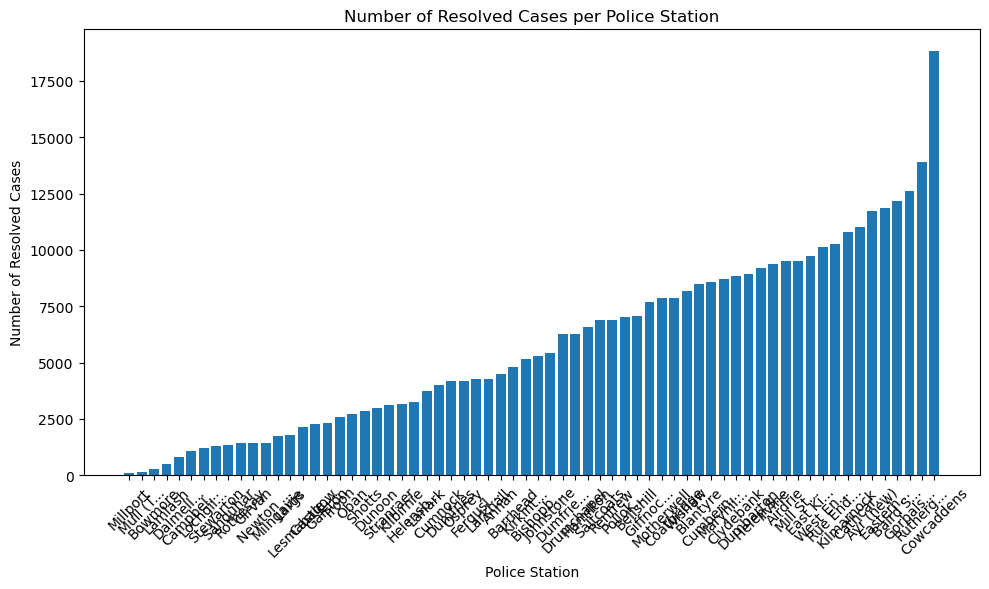

In [30]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
plt.bar(resolved_cases_per_station.sort_values("resolved")['short_name'], resolved_cases_per_station.sort_values("resolved")['resolved'])
plt.xlabel('Police Station')
plt.ylabel('Number of Resolved Cases')
plt.title('Number of Resolved Cases per Police Station')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

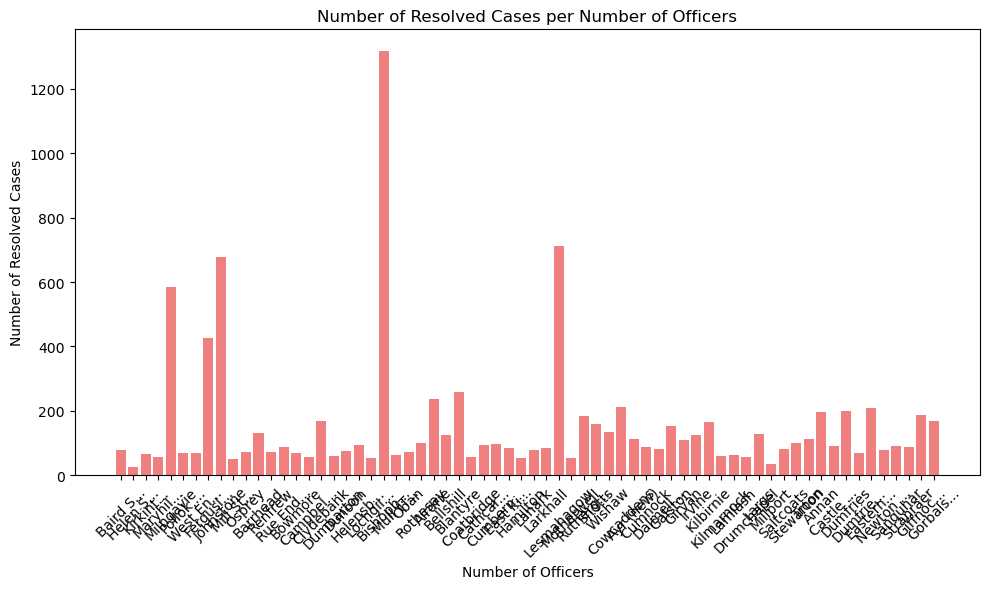

In [31]:
# Group by 'n_officers' and sum the 'resolved' column
resolved_cases_per_officers = resolved_cases_per_station['resolved']/resolved_cases_per_station['n_officers']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(resolved_cases_per_station['short_name'], resolved_cases_per_officers, color='lightcoral')
plt.xlabel('Number of Officers')
plt.ylabel('Number of Resolved Cases')
plt.title('Number of Resolved Cases per Number of Officers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
df_division = resolved_cases_per_station.groupby("division").sum()
df_division['resolved_per_officer'] = df_division['resolved'] / df_division['n_officers']
df_division = df_division.reset_index()

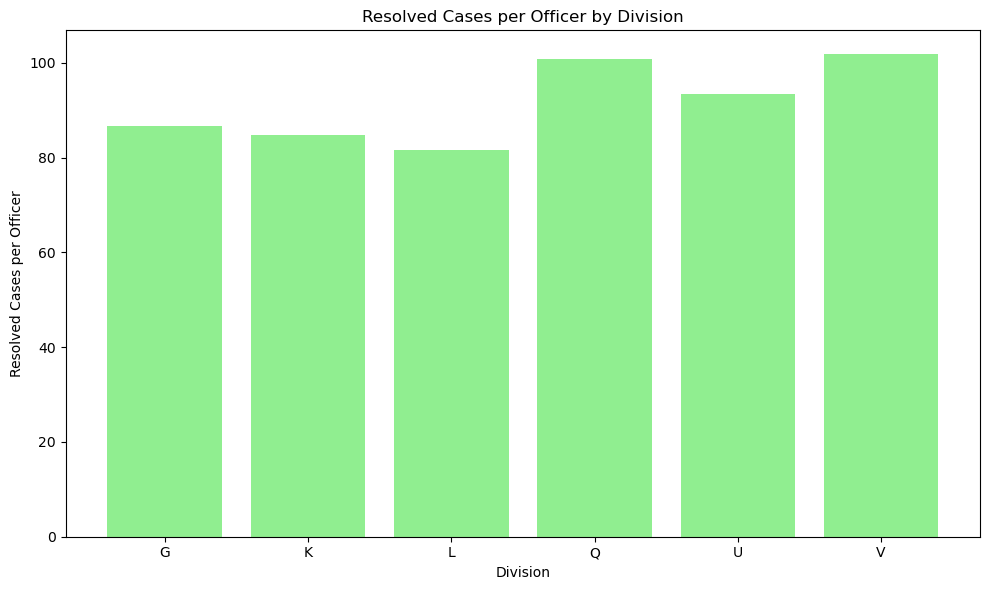

In [33]:
# Plot: Resolved cases per number of officers for each division
plt.figure(figsize=(10, 6))
plt.bar(df_division['division'], df_division['resolved_per_officer'], color='lightgreen')
plt.xlabel('Division')
plt.ylabel('Resolved Cases per Officer')
plt.title('Resolved Cases per Officer by Division')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Demand over different times for Police Stations

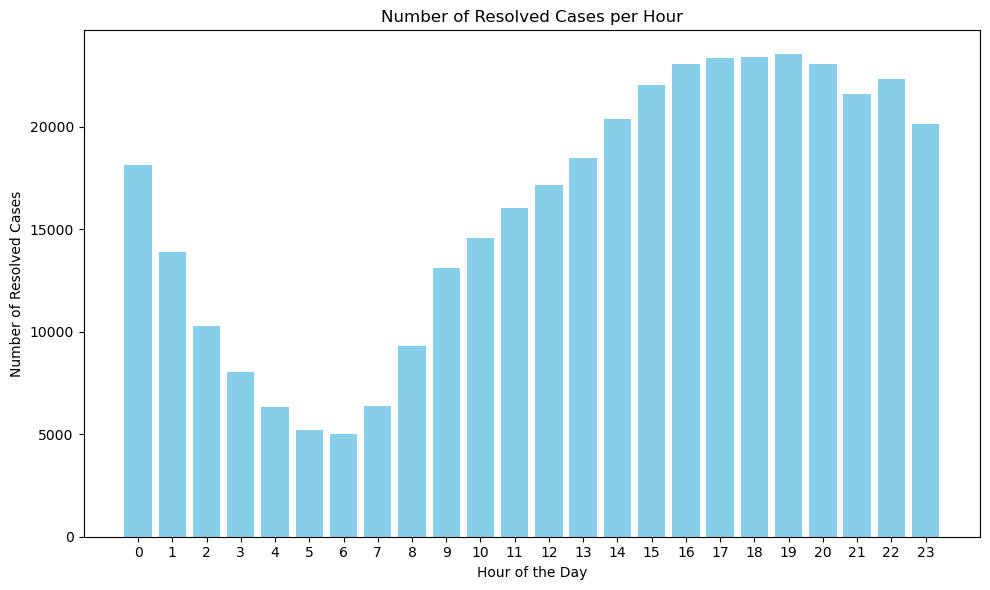

In [34]:
# Filter for resolved incidents
df_resolved = simulation.df[simulation.df['resolved']]

# Group by 'hour' and count the number of resolved cases
resolved_cases_per_hour = df_resolved.groupby('hour').size().reset_index(name='resolved_cases')

# Plot: Number of resolved cases per hour
plt.figure(figsize=(10, 6))
plt.bar(resolved_cases_per_hour['hour'], resolved_cases_per_hour['resolved_cases'], color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Resolved Cases')
plt.title('Number of Resolved Cases per Hour')
plt.xticks(resolved_cases_per_hour['hour'])
plt.tight_layout()
plt.show()

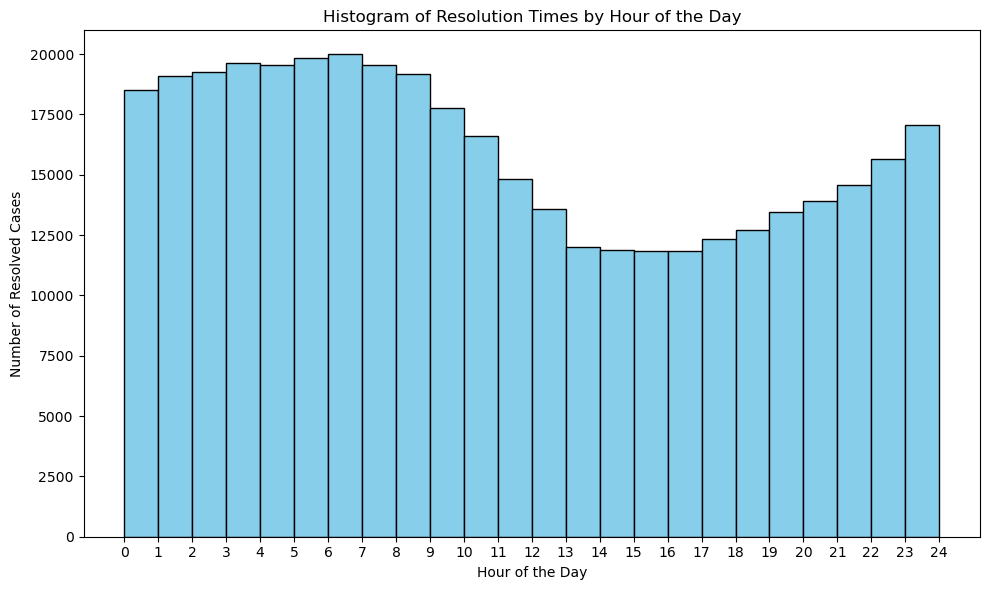

In [35]:
df_resolved['hour_of_day'] = df_resolved['resolution_time'] % 24

# Plot: Histogram of resolution times by hour of the day
plt.figure(figsize=(10, 6))
plt.hist(df_resolved['hour_of_day'], bins=24, range=(0, 24), color='skyblue', edgecolor='black')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Resolved Cases')
plt.title('Histogram of Resolution Times by Hour of the Day')
plt.xticks(range(0, 25, 1))
plt.tight_layout()
plt.show()

In [36]:
# Shift pattern 

### Urban vs Rural Demand